# Assignment 2 Parts 07a(MNIST), 07b(Cross Entropy)

## Lawrence Leroy Chieng Tze Yao (S2018935)
## WID3003 Neural Computing

In [1]:
import time
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np 
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [2]:
#Download Data

transformCustom = transforms.Compose([
                                transforms.ToTensor(), #this convert to tensor
                                transforms.Lambda(lambda x:x.view(-1))  #this flatten 28*28 into a 784 vector for each image
])


train = datasets.MNIST(root='.',train=True,transform=transformCustom, download=True)
test = datasets.MNIST(root='.', train=False, transform=transformCustom,download=True)

#Set DataLoader
batchSize = 64  # Rule of thumb is to set to the power of 2. In this case 2^7
train_loader = DataLoader(train, batch_size=batchSize,shuffle=True)
test_loader = DataLoader(test,batch_size=batchSize, shuffle=False) # no need to shuffle test data

# 1. Shallow vs Deep Network

In this assignment we want to see the effect of Shallow vs Deep Networks. Is the Deep Network a magical pill that solves all problems? What type of problems are suitable for Deep Networks? When or How does a Shallow Network be as good as Deep Networks? These are the questions that we will be pondering upon.

### 1.1 Design a few shallow and deep networks. Examples are below.
Below is shown some incomplete code on shallow vs deep vs deeper networks that I have experimented with. You don't have to do exactly the same. But you must compare a few shallow vs deep networks


In [3]:
class Arbitary_NN(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(Arbitary_NN, self).__init__()
        
        all_layers = []
        
        # Create input layer
        all_layers.append(nn.Linear(input_size, hidden_sizes[0]))
        
        # Create hidden layers
        for i in range(len(hidden_sizes) - 1):
            all_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))

        # Create output layer
        all_layers.append(nn.Linear(hidden_sizes[-1], num_classes))
        
        # Store all layers
        self.layers = nn.ModuleList(all_layers)

    def forward(self, x):
        # Pass input through each layer, using ReLU activation function except for the final layer
        for i, layer in enumerate(self.layers):
            if i == len(self.layers) - 1:
                x = layer(x)  # no activation for the final layer
            else:
                x = F.relu(layer(x))
        return x


#essentially NN of any size runs on the same principle as arbitarily defined layers
class ShallowNN(Arbitary_NN): #1 hidden layer
  def __init__(self,input_size, hidden_sizes, num_classes):
    super(ShallowNN,self).__init__(input_size, hidden_sizes, num_classes)

class DeepNN(Arbitary_NN): #2 hidden layers
  def __init__(self,input_size, hidden_sizes, num_classes):
    super(DeepNN,self).__init__(input_size, hidden_sizes, num_classes)

class DeeperNN(Arbitary_NN): #5 hidden layers
  def __init__(self,input_size, hidden_sizes, num_classes):
    super(DeeperNN,self).__init__(input_size, hidden_sizes, num_classes)


### 1.2 Train your Shallow vs Deep Network on the MNIST dataset.

As you can see below, training is a function which takes the dataset to be trained. The 'False' flag is just an indicator whether the input dataset is the noisy or original. Again, you don't have to use the same arguments.

```
model_shallow = ShallowNN(784,128, 10) #input_size,hidden_size,num_classes
model_deep = DeepNN(784,128,128,10) #input_size,hidden_size1,hidden_size2,num_classes
model_deeper = DeeperNN(784,128,16,16,16,16,10) #input_size,hidden_size1,hidden_size2,num_classes


training_shallow_loss =  training(model_shallow,train_loader,10,False)
training_deep_loss =  training(model_deep,train_loader,10,False)
training_deeper_loss =  training(model_deeper,train_loader,10,False)
```

In [4]:
def training(model, data_loader, noisy=False):
    loss_fn = nn.CrossEntropyLoss() 
    opt = torch.optim.Adam(model.parameters()) #optimizer, optimization strategy-to escape the local minima and to converge quickly
    epochSize = 10 #obviously this isn't enough
    losses = []
    total_time = 0
    
    for epoch in range(epochSize): #this training part can be made into a function, or defined as function of class MLP
        start = time.time()
        loop = tqdm(data_loader)
        loss = 0
        # Load the data 
        for index, (input_batch, target_batch) in enumerate(loop):
            if noisy:
                input_batch = add_noise(input_batch)

            #Zero the gradients
            opt.zero_grad() 
            #Forward pass
            predict_batch = model(input_batch) 
            #Compute loss
            loss_batch = loss_fn(predict_batch,target_batch)  
            #Backward pass and update weights
            loss_batch.backward() #autodifferentiation
            opt.step() #update weights

            loss += loss_batch.item() #store the loss
            
            # add stuff to progress bar in the end
            loop.set_description(f"Epoch [{epoch+1}/{epochSize}]")
            loop.set_postfix(loss=torch.rand(1).item(), acc=torch.rand(1).item())
            
        losses.append(loss)
        end = time.time()
        duration = (end - start)
        total_time += duration
        print(f'Epoch: {epoch+1}  loss: {loss} time: {duration}s')    
    print(f'Total time: {total_time}s')
    return losses


In [5]:
#Output
model_shallow = ShallowNN(784,[128], 10)
model_deep = DeepNN(784,[128,128],10)
model_deeper = DeeperNN(784,[128,16,16,16,16],10)

print('\nTraining Shallow NN:')
training_shallow_loss =  training(model_shallow,train_loader,False)
training_deep_loss =  training(model_deep,train_loader,False)
print('\nTraining Deep NN:')
training_deeper_loss =  training(model_deeper,train_loader,False)
print('\nTraining Deeper NN:')


Training Shallow NN:


Epoch [1/10]: 100%|██████████| 938/938 [00:15<00:00, 61.33it/s, acc=0.167, loss=0.148]   


Epoch: 1  loss: 316.30881298705935 time: 15.335232496261597s


Epoch [2/10]: 100%|██████████| 938/938 [00:14<00:00, 66.65it/s, acc=0.299, loss=0.557]  


Epoch: 2  loss: 143.04338343441486 time: 14.075373649597168s


Epoch [3/10]: 100%|██████████| 938/938 [00:14<00:00, 64.50it/s, acc=0.945, loss=0.782]   


Epoch: 3  loss: 100.16263973340392 time: 14.547117710113525s


Epoch [4/10]: 100%|██████████| 938/938 [00:14<00:00, 65.29it/s, acc=0.544, loss=0.924]   


Epoch: 4  loss: 76.52453461010009 time: 14.369605779647827s


Epoch [5/10]: 100%|██████████| 938/938 [00:14<00:00, 62.93it/s, acc=0.329, loss=0.334]   


Epoch: 5  loss: 60.61201849905774 time: 14.908944606781006s


Epoch [6/10]: 100%|██████████| 938/938 [00:15<00:00, 60.41it/s, acc=0.78, loss=0.224]   


Epoch: 6  loss: 48.326833768514916 time: 15.530622005462646s


Epoch [7/10]: 100%|██████████| 938/938 [00:15<00:00, 59.72it/s, acc=0.894, loss=0.642]   


Epoch: 7  loss: 39.46186118922196 time: 15.711533069610596s


Epoch [8/10]: 100%|██████████| 938/938 [00:15<00:00, 58.67it/s, acc=0.49, loss=0.122]    


Epoch: 8  loss: 32.34150581981521 time: 15.989237785339355s


Epoch [9/10]: 100%|██████████| 938/938 [00:15<00:00, 60.55it/s, acc=0.285, loss=0.686]    


Epoch: 9  loss: 26.11808460741304 time: 15.496121644973755s


Epoch [10/10]: 100%|██████████| 938/938 [00:15<00:00, 60.16it/s, acc=0.62, loss=0.289]    


Epoch: 10  loss: 21.537490080227144 time: 15.596461057662964s
Total time: 151.56024980545044s


Epoch [1/10]: 100%|██████████| 938/938 [00:16<00:00, 55.49it/s, acc=0.631, loss=0.135]   


Epoch: 1  loss: 300.5233200788498 time: 16.905046939849854s


Epoch [2/10]: 100%|██████████| 938/938 [00:17<00:00, 52.84it/s, acc=0.77, loss=0.744]    


Epoch: 2  loss: 118.95755542069674 time: 17.75826907157898s


Epoch [3/10]: 100%|██████████| 938/938 [00:15<00:00, 60.52it/s, acc=0.533, loss=0.157]   


Epoch: 3  loss: 81.58961068931967 time: 15.503129005432129s


Epoch [4/10]: 100%|██████████| 938/938 [00:16<00:00, 56.77it/s, acc=0.47, loss=0.765]    


Epoch: 4  loss: 60.48397919582203 time: 16.52716374397278s


Epoch [5/10]: 100%|██████████| 938/938 [00:16<00:00, 55.19it/s, acc=0.558, loss=0.462]   


Epoch: 5  loss: 48.8483160098549 time: 17.001780033111572s


Epoch [6/10]: 100%|██████████| 938/938 [00:16<00:00, 56.39it/s, acc=0.454, loss=0.32]    


Epoch: 6  loss: 37.28293535474222 time: 16.638341665267944s


Epoch [7/10]: 100%|██████████| 938/938 [00:17<00:00, 52.88it/s, acc=0.26, loss=0.278]     


Epoch: 7  loss: 30.189108129416127 time: 17.74084234237671s


Epoch [8/10]: 100%|██████████| 938/938 [00:16<00:00, 56.05it/s, acc=0.296, loss=0.841]    


Epoch: 8  loss: 26.11475616117241 time: 16.738608837127686s


Epoch [9/10]: 100%|██████████| 938/938 [00:17<00:00, 55.16it/s, acc=0.387, loss=0.7]     


Epoch: 9  loss: 21.460284424363635 time: 17.00820255279541s


Epoch [10/10]: 100%|██████████| 938/938 [00:15<00:00, 58.77it/s, acc=0.327, loss=0.21]    


Epoch: 10  loss: 20.360836738385842 time: 15.964571475982666s
Total time: 167.78595566749573s

Training Deep NN:


Epoch [1/10]: 100%|██████████| 938/938 [00:16<00:00, 57.49it/s, acc=0.542, loss=0.498]   


Epoch: 1  loss: 602.693063698709 time: 16.31988549232483s


Epoch [2/10]: 100%|██████████| 938/938 [00:15<00:00, 59.22it/s, acc=0.471, loss=0.961]   


Epoch: 2  loss: 213.15715420991182 time: 15.841897249221802s


Epoch [3/10]: 100%|██████████| 938/938 [00:15<00:00, 59.29it/s, acc=0.919, loss=0.703]   


Epoch: 3  loss: 149.9279563780874 time: 15.824501991271973s


Epoch [4/10]: 100%|██████████| 938/938 [00:15<00:00, 59.55it/s, acc=0.144, loss=0.0163]  


Epoch: 4  loss: 117.27355097979307 time: 15.755329608917236s


Epoch [5/10]: 100%|██████████| 938/938 [00:15<00:00, 59.41it/s, acc=0.71, loss=0.288]    


Epoch: 5  loss: 93.42416781559587 time: 15.790992259979248s


Epoch [6/10]: 100%|██████████| 938/938 [00:15<00:00, 59.07it/s, acc=0.392, loss=0.125]   


Epoch: 6  loss: 78.70320289069787 time: 15.884002447128296s


Epoch [7/10]: 100%|██████████| 938/938 [00:15<00:00, 59.46it/s, acc=0.631, loss=0.758]   


Epoch: 7  loss: 67.79518261109479 time: 15.777549028396606s


Epoch [8/10]: 100%|██████████| 938/938 [00:16<00:00, 57.24it/s, acc=0.786, loss=0.337]  


Epoch: 8  loss: 58.46789918211289 time: 16.391346216201782s


Epoch [9/10]: 100%|██████████| 938/938 [00:16<00:00, 55.91it/s, acc=0.591, loss=0.245]   


Epoch: 9  loss: 48.72500406054314 time: 16.780450582504272s


Epoch [10/10]: 100%|██████████| 938/938 [00:17<00:00, 53.07it/s, acc=0.73, loss=0.3]      

Epoch: 10  loss: 42.54595012310892 time: 17.67787265777588s
Total time: 162.04382753372192s

Training Deeper NN:


### 1.3 Visualize the training loss vs epoch for all shallow vs deep networks

In the figures below, I've played around with the number of neurons in each hidden layers for all of my networks defined earlier, to give you a variety of output.  

You should try to output at least a single figure as below. Better to compare to vary the architecture of the networks to show what is working and what isn't working ('working' defined as in deeper networks outperforms shallow networks).Hopefully the loss went down as the models learned!


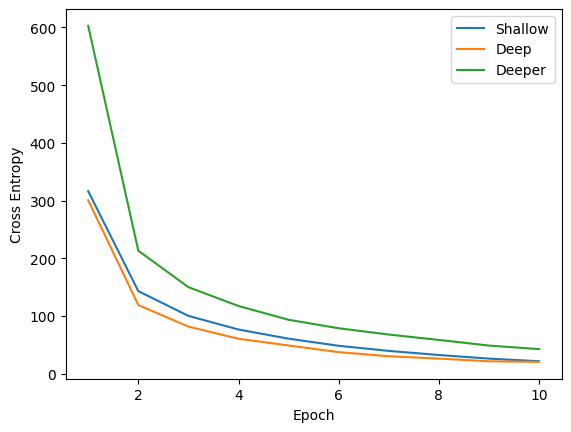

In [6]:
for losses in [training_shallow_loss, training_deep_loss, training_deeper_loss]:
    plt.plot(list(range(1,len(losses)+1)), losses)
plt.legend(['Shallow', 'Deep', 'Deeper'])
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.show()

### 1.4 Evaluation of trained model on trained data

Previously we've computed the loss vs epoch. But now we want to evaluate the trained models and their predictions against the training and test dataset. Hence we would need to compute the overall accuracy of the training and test set. Note you need to make a call to model.eval() - this sets the model into evaluation mode and supresses non-training things (gradients, and things such as dropout being applied/computed).

Some samples of the output are given below.


```
print('----Model Shallow-----\n')
evaluate_model(model_shallow,train_loader,test_loader)

print('\n----Model Deep-----')
evaluate_model(model_deep,train_loader,test_loader)

print('\n----Model Deeper-----')
evaluate_model(model_deeper,train_loader,test_loader)
```

In [7]:
#Sample output
def compute_accuracy(model, data_loader):
  total = correct = 0
  model.eval() # sets the model in evaluation mode 
  for input_batch, target_batch in data_loader: #data_loader can take train or test dataset
    predict_batch = model(input_batch)     
    _, predicted = torch.max(predict_batch.data, 1)
    total += target_batch.size(0)
    correct += (predicted == target_batch).sum().item()
  print(f'number of evaluated data: {total}')
  print(f'number of wrongly predicted label: {total - correct}')
  print(f'Accuracy: {100 * correct / total}%')

for model_name, model in [('Shallow NN', model_shallow), ('Deep NN', model_deep), ('Deeper NN', model_deeper)]:
  print(model_name)
  for data_name, data_loader in [('Training Set', train_loader), ('Test Set', test_loader)]:
    print(data_name)
    compute_accuracy(model, data_loader)
  print()



Shallow NN
Training Set
number of evaluated data: 60000
number of wrongly predicted label: 254
Accuracy: 99.57666666666667%
Test Set
number of evaluated data: 10000
number of wrongly predicted label: 197
Accuracy: 98.03%

Deep NN
Training Set
number of evaluated data: 60000
number of wrongly predicted label: 306
Accuracy: 99.49%
Test Set
number of evaluated data: 10000
number of wrongly predicted label: 233
Accuracy: 97.67%

Deeper NN
Training Set
number of evaluated data: 60000
number of wrongly predicted label: 545
Accuracy: 99.09166666666667%
Test Set
number of evaluated data: 10000
number of wrongly predicted label: 263
Accuracy: 97.37%



# 2. Noisy inputs

In this assignment, we'll be adding noise to the original inputs and see how they affect the performance of the models. Obviously we are expecting the models (regardless shallow or deep networks) to perform relatively poor compared to the original dataset.

### 2.1 Add some noise to the original data and visualize a few of the images

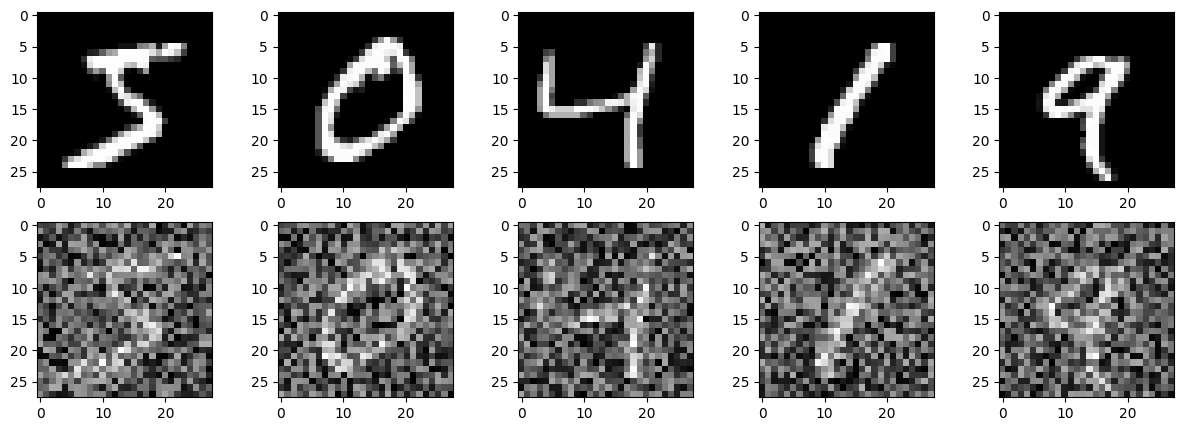

In [8]:
def add_noise(images):
    std_dev = 500
    mean = 100
    noisy_images = images + torch.rand_like(images, dtype=torch.float) * std_dev + mean
    return noisy_images

noisy_train = add_noise(train_loader.dataset.data)
# Plot a few images before and after adding noise
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))
for i in range(5):
    axes[0, i].imshow(train.data[i], cmap='gray')
    axes[1, i].imshow(noisy_train[i], cmap='gray')

plt.show()

### 2.2 Train some models on the noisy dataset

This stage is the same as the training on the original input. As you might have figured out by now, I'm adding noise to the input as we train instead of creating a noisy dataset first. But that is just me, you can do whatever style and approach you like.

```
model_shallow = ShallowNN(784,128, 10) #input_size,hidden_size,num_classes
model_deep = DeepNN(784,128,128,10) #input_size,hidden_size1,hidden_size2,num_classes
model_deeper = DeeperNN(784,512,312,256,7,784,10) 

training_shallow_loss_noisy =  training(model_shallow,train_loader,10,True)
training_deep_loss_noisy =  training(model_deep,train_loader,10,True)
training_deeper_loss_noisy =  training(model_deeper,train_loader,10,True)
```

In [9]:
print('\nTraining Shallow NN:')
training_shallow_loss_noisy =  training(model_shallow,train_loader,True)
print('\nTraining Deep NN:')
training_deep_loss_noisy =  training(model_deep,train_loader,True)
print('\nTraining Deeper NN:')
training_deeper_loss_noisy =  training(model_deeper,train_loader,True)


Training Shallow NN:


Epoch [1/10]: 100%|██████████| 938/938 [00:16<00:00, 56.53it/s, acc=0.122, loss=0.217]  


Epoch: 1  loss: 922882.0880737305 time: 16.595311164855957s


Epoch [2/10]: 100%|██████████| 938/938 [00:17<00:00, 54.39it/s, acc=0.00395, loss=0.861] 


Epoch: 2  loss: 321707.26460266113 time: 17.24867296218872s


Epoch [3/10]: 100%|██████████| 938/938 [00:18<00:00, 51.83it/s, acc=0.497, loss=0.869]   


Epoch: 3  loss: 114938.23355102539 time: 18.101134300231934s


Epoch [4/10]: 100%|██████████| 938/938 [00:18<00:00, 50.37it/s, acc=0.457, loss=0.749]   


Epoch: 4  loss: 65968.64626312256 time: 18.626012086868286s


Epoch [5/10]: 100%|██████████| 938/938 [00:22<00:00, 41.79it/s, acc=0.92, loss=0.0639]   


Epoch: 5  loss: 48517.2103099823 time: 22.452698945999146s


Epoch [6/10]: 100%|██████████| 938/938 [00:22<00:00, 41.52it/s, acc=0.0465, loss=0.157]  


Epoch: 6  loss: 43083.964347839355 time: 22.599965572357178s


Epoch [7/10]: 100%|██████████| 938/938 [00:19<00:00, 46.95it/s, acc=0.566, loss=0.585]   


Epoch: 7  loss: 34829.183117866516 time: 19.981467962265015s


Epoch [8/10]: 100%|██████████| 938/938 [00:22<00:00, 40.93it/s, acc=0.188, loss=0.565]   


Epoch: 8  loss: 31905.331699371338 time: 22.92561936378479s


Epoch [9/10]: 100%|██████████| 938/938 [00:23<00:00, 40.45it/s, acc=0.998, loss=0.683]  


Epoch: 9  loss: 26474.522161483765 time: 23.191617727279663s


Epoch [10/10]: 100%|██████████| 938/938 [00:20<00:00, 46.03it/s, acc=0.146, loss=0.962]   


Epoch: 10  loss: 22593.50102329254 time: 20.383655071258545s
Total time: 202.10615515708923s

Training Deep NN:


Epoch [1/10]: 100%|██████████| 938/938 [00:22<00:00, 42.20it/s, acc=0.209, loss=0.787]   


Epoch: 1  loss: 255801.4296388626 time: 22.23244047164917s


Epoch [2/10]: 100%|██████████| 938/938 [00:21<00:00, 43.77it/s, acc=0.508, loss=0.651]    


Epoch: 2  loss: 10358.4614443779 time: 21.436620950698853s


Epoch [3/10]: 100%|██████████| 938/938 [00:20<00:00, 46.44it/s, acc=0.341, loss=0.687]   


Epoch: 3  loss: 4191.153963804245 time: 20.201018810272217s


Epoch [4/10]: 100%|██████████| 938/938 [00:20<00:00, 44.92it/s, acc=0.537, loss=0.0101]  


Epoch: 4  loss: 2968.469160556793 time: 20.884774446487427s


Epoch [5/10]: 100%|██████████| 938/938 [00:21<00:00, 44.49it/s, acc=0.835, loss=0.746]   


Epoch: 5  loss: 2697.550004720688 time: 21.088491916656494s


Epoch [6/10]: 100%|██████████| 938/938 [00:22<00:00, 40.81it/s, acc=0.658, loss=0.29]    


Epoch: 6  loss: 2580.8619866371155 time: 22.98999333381653s


Epoch [7/10]: 100%|██████████| 938/938 [00:20<00:00, 46.27it/s, acc=0.213, loss=0.94]    


Epoch: 7  loss: 2326.393509864807 time: 20.27649211883545s


Epoch [8/10]: 100%|██████████| 938/938 [00:20<00:00, 45.37it/s, acc=0.969, loss=0.636]   


Epoch: 8  loss: 2161.178323030472 time: 20.680399179458618s


Epoch [9/10]: 100%|██████████| 938/938 [00:20<00:00, 44.94it/s, acc=0.793, loss=0.22]    


Epoch: 9  loss: 2162.4034445285797 time: 20.878224849700928s


Epoch [10/10]: 100%|██████████| 938/938 [00:20<00:00, 45.29it/s, acc=0.0375, loss=0.556]  


Epoch: 10  loss: 2158.871559381485 time: 20.71677041053772s
Total time: 211.3852264881134s

Training Deeper NN:


Epoch [1/10]: 100%|██████████| 938/938 [00:20<00:00, 45.86it/s, acc=0.715, loss=0.588]    


Epoch: 1  loss: 313531.6175904274 time: 20.456995487213135s


Epoch [2/10]: 100%|██████████| 938/938 [00:19<00:00, 48.07it/s, acc=0.922, loss=0.327]   


Epoch: 2  loss: 2215.599771499634 time: 19.517127990722656s


Epoch [3/10]: 100%|██████████| 938/938 [00:19<00:00, 46.95it/s, acc=0.751, loss=0.306]   


Epoch: 3  loss: 2174.5188341140747 time: 19.984587907791138s


Epoch [4/10]: 100%|██████████| 938/938 [00:20<00:00, 45.75it/s, acc=0.738, loss=0.417]  


Epoch: 4  loss: 2164.3254721164703 time: 20.503908395767212s


Epoch [5/10]: 100%|██████████| 938/938 [00:20<00:00, 45.13it/s, acc=0.798, loss=0.165]   


Epoch: 5  loss: 2160.2622051239014 time: 20.78946805000305s


Epoch [6/10]: 100%|██████████| 938/938 [00:20<00:00, 45.00it/s, acc=0.458, loss=0.299]   


Epoch: 6  loss: 2161.171270608902 time: 20.8501718044281s


Epoch [7/10]: 100%|██████████| 938/938 [00:20<00:00, 45.16it/s, acc=0.627, loss=0.903]    


Epoch: 7  loss: 2160.3812289237976 time: 20.77478790283203s


Epoch [8/10]: 100%|██████████| 938/938 [00:20<00:00, 44.89it/s, acc=0.897, loss=0.443]    


Epoch: 8  loss: 2159.179737329483 time: 20.90127992630005s


Epoch [9/10]: 100%|██████████| 938/938 [00:20<00:00, 44.77it/s, acc=0.845, loss=0.672]  


Epoch: 9  loss: 2158.7757816314697 time: 20.95591974258423s


Epoch [10/10]: 100%|██████████| 938/938 [00:20<00:00, 45.43it/s, acc=0.463, loss=0.682]    

Epoch: 10  loss: 2160.1820769309998 time: 20.652835607528687s
Total time: 205.3870828151703s


### 2.3 Visualization of the training loss for noisy input

In this visualization, I compared the performance of shallow vs deep networks for noisy data. And I also compared the performance of all models to see the effect of noisy and original data. 

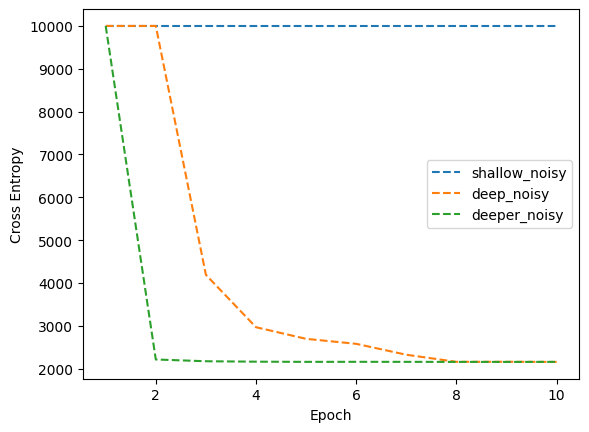

In [10]:
for losses in [training_shallow_loss_noisy, training_deep_loss_noisy, training_deeper_loss_noisy]:
    #OPTIONAL: trim vals over 10000
    y = []
    for val in losses:
        y.append(min(val, 10000)) 
    plt.plot(list(range(1,len(losses)+1)), y, '--')
    # plt.plot(list(range(1,len(losses)+1)), losses, '--')
plt.legend(['shallow_noisy', 'deep_noisy', 'deeper_noisy'])
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.show()

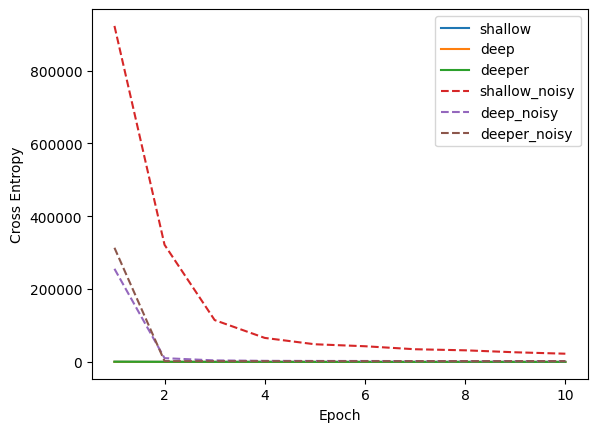

In [11]:
for losses in [training_shallow_loss, training_deep_loss, training_deeper_loss]:
    plt.plot(list(range(1,len(losses)+1)), losses)
for losses in [training_shallow_loss_noisy, training_deep_loss_noisy, training_deeper_loss_noisy]:
    
    plt.plot(list(range(1,len(losses)+1)), losses, '--')
plt.legend(['shallow', 'deep', 'deeper', 'shallow_noisy', 'deep_noisy', 'deeper_noisy'])
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.show()

### 2.4 Evaluation against training and test dataset

This is also the same as Part 1. Only we expect the model accuracy to be poorer for noisy input compared to the original images.

In [12]:
for model_name, model in [('Shallow NN', model_shallow), ('Deep NN', model_deep), ('Deeper NN', model_deeper)]:
  print(model_name)
  for data_name, data_loader in [('Training Set', train_loader), ('Test Set', test_loader)]:
    print(data_name)
    compute_accuracy(model, data_loader)
  print()



Shallow NN
Training Set
number of evaluated data: 60000
number of wrongly predicted label: 6044
Accuracy: 89.92666666666666%
Test Set
number of evaluated data: 10000
number of wrongly predicted label: 1141
Accuracy: 88.59%

Deep NN
Training Set
number of evaluated data: 60000
number of wrongly predicted label: 4872
Accuracy: 91.88%
Test Set
number of evaluated data: 10000
number of wrongly predicted label: 971
Accuracy: 90.29%

Deeper NN
Training Set
number of evaluated data: 60000
number of wrongly predicted label: 26880
Accuracy: 55.2%
Test Set
number of evaluated data: 10000
number of wrongly predicted label: 4513
Accuracy: 54.87%



# 3. Cross Entropy between Original input and Noisy input

### 3.1 

Assume that the original input is the 'ground truth' and the noisy input is your probabilistic model of the MNIST images. What is the cross entropy between these two distribution by class?

In this assignment, we assume only the training data represents the ground truth for handwritten digits. This means that all 7~8 billion people of the world, would only write handwritten digits in the style captured by the 60,000 images of the training data. So this training data represents our ground truth.

Now imagine if the 60,000 images of the training data is added noise and corruptied to some point. (Of course how 'corrupt' you want the images to be is up to you. You can try different level of corruptness.)

To make your/our lives easier, we'll just look at the digit 'zero'. So all 7-8 billion people of the world, write the number 'zero' in the style captured by the images of 'zero' in the training data. Careful, the amount of images zero in the training data is obviously not 60,000.


So first, create a dataset of images 'zero' with noise added. Here the original images of zero is labelled as 'image0' and the corrupted ones as 'image0_noisy'. Please visualize the first (or the first few) original images and noisy images as below.  


```

plt.subplot(1,2,1)
show_flattened_image(image0[0])

plt.subplot(1,2,2)
show_flattened_image(image0_noisy[0])

```

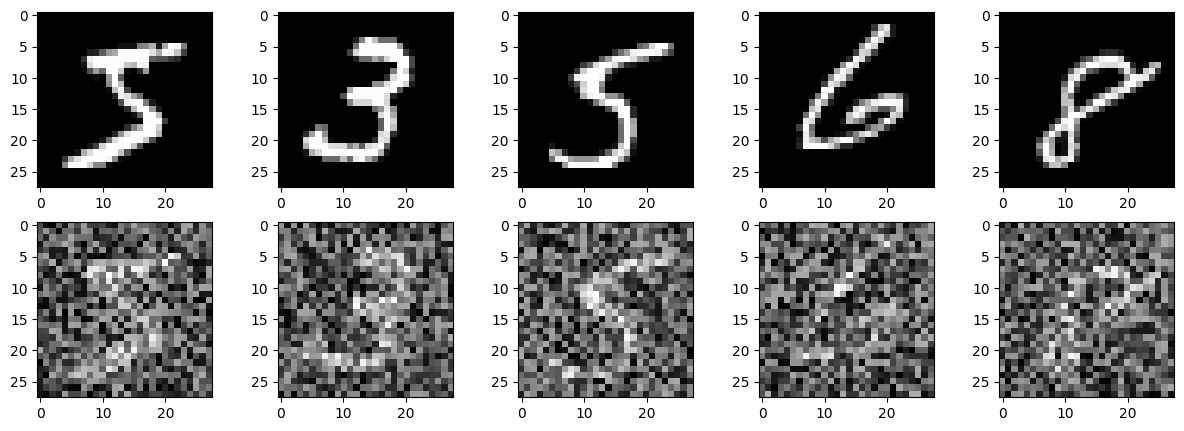

In [13]:
#Sample output
noisy_train = add_noise(train.data)
# Plot a few images before and after adding noise
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))
for i in range(0,-5,-1):
    axes[0, i].imshow(train.data[i], cmap='gray')
    axes[1, i].imshow(noisy_train[i], cmap='gray')

plt.show()

### 3.2 Compute probability distribution

Next we need to compute the probability distribution for both image0 and image0_noisy. For an image, we know that each pixel can take the values of 0~255. Let's think, for example, what is the probability that the value 255 occurs in our data(data= image0, image0_noisy)?

So we need to count how many times the value 255 occurs in ALL OF OUR IMAGES. And then we normalized the number of counts to probabilities. 

Below is shown the probability distribution where x-axis is the values 0~255 and y-axis is the probability value. The upper figure is the probability distribution for the orignal image, image0 and the lower figure is the probability distribution for the noisy images or image0_noisy. The value 0 has the highest probability because there are lots of 'dark' areas in all images. This is true regardless of the number anyway.

```

probability_dist = compute_probability(image0)

probability_dist_noisy = compute_probability(image0_noisy)
```


In [14]:
def compute_probability(image):
    dist = torch.empty(256)
    total = torch.numel(image)
    for i in range(256):
        mask = (image == i)
        dist[i] = len(image[mask]) / total
    return dist

Digit 0 matrix shape: torch.Size([5923, 28, 28])
Digit 1 matrix shape: torch.Size([6742, 28, 28])
Digit 2 matrix shape: torch.Size([5958, 28, 28])
Digit 3 matrix shape: torch.Size([6131, 28, 28])
Digit 4 matrix shape: torch.Size([5842, 28, 28])
Digit 5 matrix shape: torch.Size([5421, 28, 28])
Digit 6 matrix shape: torch.Size([5918, 28, 28])
Digit 7 matrix shape: torch.Size([6265, 28, 28])
Digit 8 matrix shape: torch.Size([5851, 28, 28])
Digit 9 matrix shape: torch.Size([5949, 28, 28])


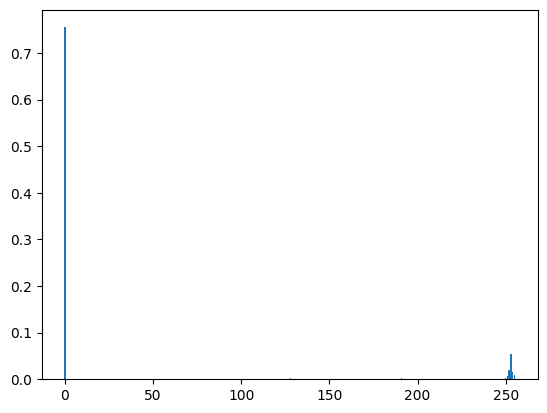

In [15]:
#sort train set into classes
sorted_train = {}
for i in range(10):
    mask = (train.targets == i)
    sorted_train[i] = train.data[mask]
    print(f"Digit {i} matrix shape: {sorted_train[i].shape}")
    
#get all class=0 images   
image0 = sorted_train[0]
dist = compute_probability(image0)
plt.bar(list(range(256)), dist)
plt.show()

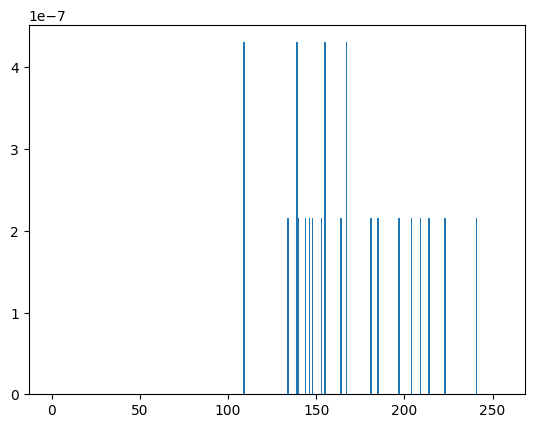

In [16]:
image0_noisy = add_noise(image0)
dist_noisy = compute_probability(image0_noisy)
plt.bar(list(range(256)), dist_noisy)
plt.show()

### 3.3 Compute Cross Entropy distribution 

Now that we have the probabily distribution for the original image0 and corrupted images, image0_noisy, we can compute the Cross Entropy distribution defined as

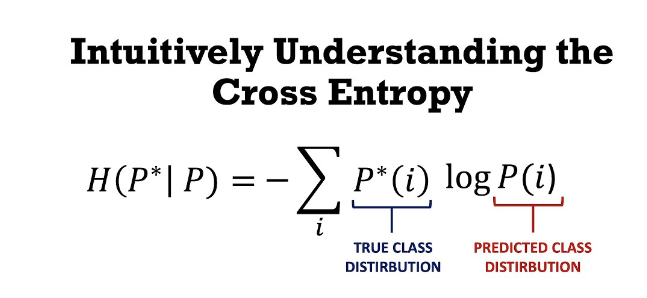

Total Cross Entropy : 22.953632354736328


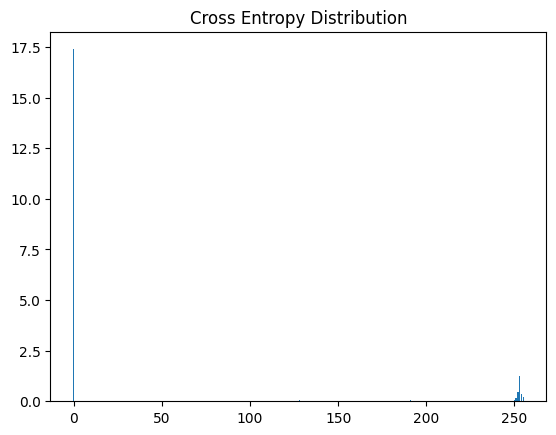

In [17]:
#Cross entropy between original and noisy distribution
dist_noisy += 1e-10
entropy = -1 * dist * torch.log(dist_noisy)

print(f'Total Cross Entropy : {torch.sum(entropy)}')
plt.bar(list(range(256)), entropy)
plt.title('Cross Entropy Distribution')
plt.show()

# *Extra:* Side-by-Side Comparison of Clean, Noisy and Cross Entropy 

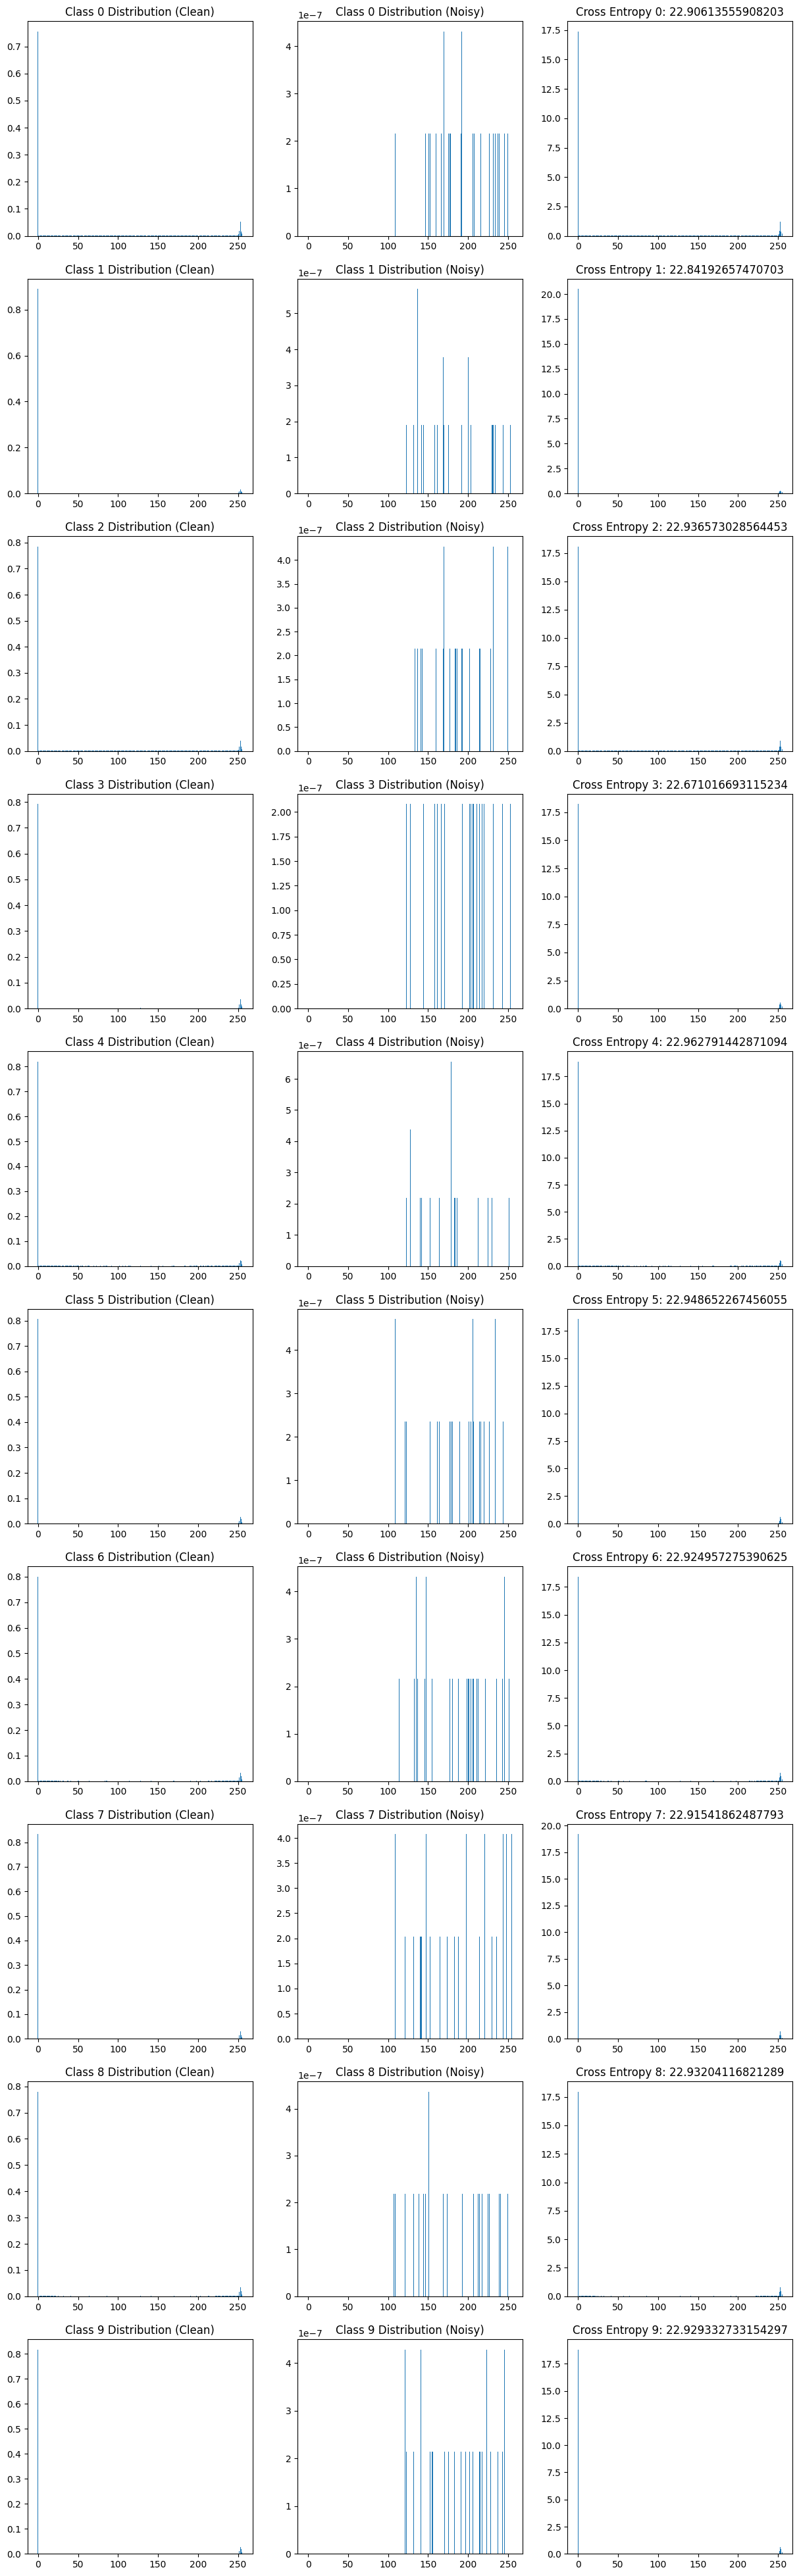

{0: {'clean': tensor([7.5513e-01, 5.6120e-04, 7.6513e-04, 8.4610e-04, 8.9154e-04, 9.4473e-04,
          8.9004e-04, 9.8005e-04, 7.8128e-04, 8.9004e-04, 8.0863e-04, 8.5644e-04,
          7.7827e-04, 9.2234e-04, 6.7447e-04, 7.4812e-04, 6.6521e-04, 6.4239e-04,
          5.9242e-04, 8.1983e-04, 7.6147e-04, 8.4029e-04, 6.3808e-04, 5.3127e-04,
          6.3980e-04, 7.7181e-04, 5.6378e-04, 5.9178e-04, 7.0505e-04, 8.7625e-04,
          5.6551e-04, 7.2896e-04, 8.2112e-04, 4.0981e-04, 5.0112e-04, 6.5681e-04,
          5.4871e-04, 6.8266e-04, 6.5961e-04, 4.2811e-04, 5.1145e-04, 6.3636e-04,
          5.8338e-04, 5.1468e-04, 3.9344e-04, 5.5560e-04, 4.0529e-04, 6.5811e-04,
          5.3665e-04, 4.3048e-04, 5.3385e-04, 5.9587e-04, 3.3874e-04, 4.8087e-04,
          4.4426e-04, 3.9086e-04, 6.7404e-04, 8.1466e-04, 3.2087e-04, 4.6558e-04,
          4.6709e-04, 4.2833e-04, 5.3536e-04, 6.4346e-04, 1.4260e-03, 4.0055e-04,
          4.5417e-04, 4.0464e-04, 3.9753e-04, 3.4908e-04, 4.4534e-04, 5.0392e-04,
    

In [18]:
#get all images   
distribution = {i:{} for i in range(10)}
dim = 5
fig, ax = plt.subplots(nrows=10, ncols=3, figsize=(3*dim, 10*dim))
x_axis = list(range(256))
for i, image in sorted_train.items():
    #clean image
    dist_clean = compute_probability(image)
    distribution[i]['clean'] = dist_clean
    ax[i, 0].bar(x_axis, dist_clean)
    ax[i, 0].set_title(f'Class {i} Distribution (Clean)')
    
    #noisy image
    image_noisy = add_noise(image)
    dist_noisy = compute_probability(image_noisy)
    distribution[i]['noisy'] = dist_noisy
    ax[i, 1].bar(x_axis, dist_noisy)
    ax[i, 1].set_title(f'Class {i} Distribution (Noisy)')
    
    #cross entropy
    dist_noisy += 1e-10
    entropy = -1 * dist_clean * torch.log(dist_noisy)
    distribution[i]['entropy'] = entropy
    ax[i, 2].bar(x_axis, entropy)
    ax[i, 2].set_title(f'Cross Entropy {i}: {torch.sum(entropy)}')

plt.show()
distribution